In [2]:
#SPEECH EMOTION RECOGNITION
#importing the modules required for speech emotion recognition.
import librosa
import librosa.display
import os
import pandas as pd
import glob 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras import regularizers
import scipy.io.wavfile
import sys
from sklearn.utils import shuffle

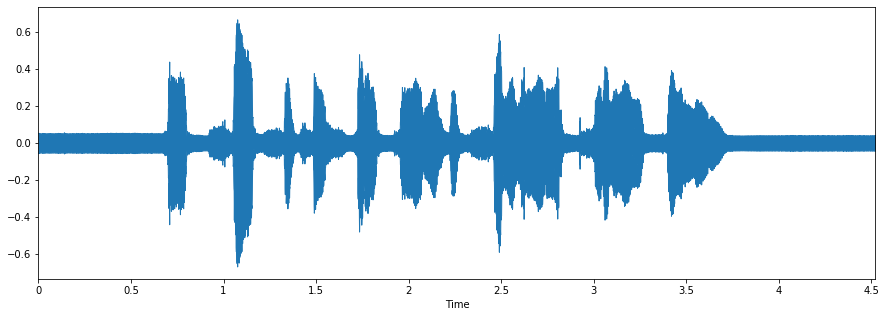

In [5]:
#accessing the dataset which is available in the internet(RAVDESS)
mylist= os.listdir('./RawData/RawData/')
#since the dataset is in audio format we use librosa module to load the wav files.
data, sampling_rate = librosa.load('./RawData/RawData/f11 (2).wav')
#ploting the wav file for visualizing it.
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

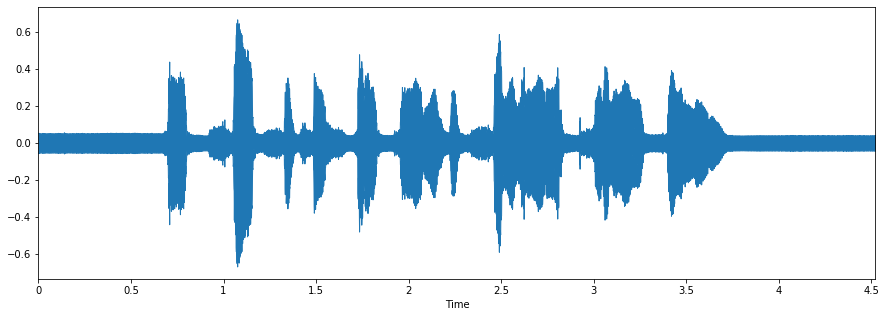

In [6]:
#ploting the wav file for visualizing it.
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

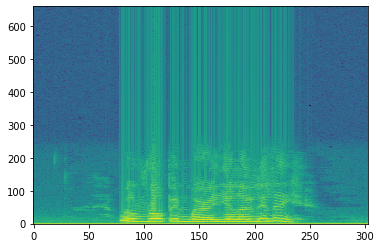

In [7]:
#x axis will show the number of epochs and y axis deals with training bales.
sr,x = scipy.io.wavfile.read('./RawData/RawData/f10 (2).wav')
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin
window = np.hamming(nwin)
## will take windows x[n1:n2] generate and loop over n2 such that all frames fit within the waveform
nn = range(nwin, len(x), nstep)
X = np.zeros( (len(nn), nfft//2) )
for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))
plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')
plt.show()

In [244]:
#collecting all the emotions in a list and assigning a integer value to each emotion so that softmax will recognize it.
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
        #female calm emotion
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
        #male calm emotion
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
        #female happy emotion
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
        #male happy emotion
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
        #female sad emotion
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
        #male sad emotion
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
        #female angry emotion
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
        #male angry emotion
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
        #female fearful emotion
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
        #male fearful emotion
    elif item[:1]=='a':
        feeling_list.append('male_angry')
        #male angry emotion
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
        #male fearful emotion
    elif item[:1]=='h':
        feeling_list.append('male_happy')
        #male happy emotion
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [245]:
#converting emotions list as a output training list.
labels = pd.DataFrame(feeling_list)
#printing the output list.
labels[:10]

,0
0,male_happy
1,male_calm
2,female_sad
3,male_angry
4,male_sad
5,male_happy
6,female_calm
7,male_fearful
8,male_sad
9,male_sad


In [8]:
#all about features.i.e, extracting the features from the datasetand using them in training the model.
dataframe = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('./RawData/RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        dataframe.loc[bookmark] = [feature]
        bookmark=bookmark+1

In [249]:
#converting the dataframe by splitting the features and the labels.
dataf3 = pd.DataFrame(dataframe['feature'].values.tolist())
newdataf = pd.concat([dataf3,labels], axis=1)
rnewdataf = newdataf.rename(index=str, columns={"0": "label"})

In [250]:
rnewdataf = shuffle(newdataf)
rnewdataf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
39,-56.357246,-55.912090,-53.390030,-54.204491,-51.211483,-51.550980,-50.826828,-50.698997,-51.794853,-52.526184,...,-52.346367,-52.856991,-52.708591,-52.077278,-50.171062,-49.525398,-50.240929,-52.254951,-54.420170,male_happy
1162,-54.900043,-54.900043,-54.900043,-54.900043,-54.900043,-54.900043,-54.900043,-54.900043,-54.900043,-54.900043,...,-54.900043,-54.900043,-54.900043,-54.900043,-54.900043,-54.900043,-54.900043,-54.585144,-54.452507,female_angry
816,-50.395935,-52.036766,-53.322956,-53.681828,-53.737862,-52.723572,-51.938457,-51.223721,-52.601021,-52.437778,...,-28.124722,-28.800528,-28.736744,-28.625130,-29.070343,-29.151937,-29.545986,-29.642235,-27.836395,male_calm
573,-58.702000,-61.211185,-59.182697,-60.142807,-65.112366,-65.575691,-65.575691,-65.575691,-63.246399,-58.243263,...,-60.142990,-57.386471,-56.711552,-56.970543,-58.692673,-62.731918,-59.266068,-58.824970,-62.470280,male_calm
962,-57.016701,-58.805046,-59.815811,-60.208458,-60.511356,-61.271866,-62.353725,-62.433777,-62.202007,-62.037945,...,-60.914787,-60.786404,-59.572769,-57.718071,-59.889156,-60.660194,-62.115704,-61.575138,-59.090836,female_happy
281,-44.248680,-43.841702,-43.668682,-43.712418,-44.508335,-44.366554,-43.898586,-43.700363,-43.947857,-44.075687,...,-31.253090,-31.903154,-33.519962,-32.682991,-33.867683,-33.935936,-37.244991,-36.575264,-35.585732,male_angry
273,-64.239586,-59.648708,-58.627792,-59.089966,-58.097431,-59.788513,-60.138027,-60.045170,-58.868126,-61.057785,...,-60.807762,-61.468388,-60.356136,-58.673332,-61.760384,-70.771698,-73.384247,-68.288635,-66.014908,male_sad
562,-52.120098,-51.624870,-49.452751,-47.018253,-42.051262,-38.245033,-36.825676,-36.134842,-36.307175,-36.386368,...,-51.343357,-50.900490,-49.770729,-49.436905,-49.256985,-49.062111,-48.616753,-45.257561,-41.612503,female_sad
1164,-46.696663,-46.092934,-46.639221,-47.010025,-47.230556,-47.697536,-47.697536,-47.697536,-47.697536,-47.697536,...,-45.065880,-44.751480,-44.250473,-45.001236,-42.661335,-43.193027,-43.266705,-43.577316,-45.003353,male_angry
508,-71.342896,-62.746868,-57.570778,-53.169498,-49.153439,-47.136345,-45.943577,-45.421463,-45.818741,-44.558800,...,-54.856247,-53.210648,-55.993076,-56.948860,-54.306679,-56.847832,-59.806309,-56.321743,-58.451782,male_sad


In [186]:
rnewdataf=rnewdataf.fillna(0)


In [187]:
#dividing and assigning the training and testing data
newdataf1 = np.random.rand(len(rnewdataf)) < 0.8
training = rnewdataf[newdataf1]
testing = rnewdataf[~newdataf1]

In [189]:
#training data corresponding to xaxis
xtrain = training.iloc[:, :-1]
#training data corresponding to y axis
ytrain = training.iloc[:, -1:]
#testing data corresponding to x axis.
xtest = testing.iloc[:, :-1]
#testing data corresponding to y axis
ytest = testing.iloc[:, -1:]

In [193]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
#converting the lists into one hot vectors using numpy module so that the convolutional layers accept them as input
trainingX = np.array(xtrain)
trainingY = np.array(ytrain)
testingX = np.array(xtest)
testingY = np.array(ytest)

lben = LabelEncoder()
#categerizing the training and testing data.
trainingY = np_utils.to_categorical(lben.fit_transform(trainingY))
testingY = np_utils.to_categorical(lben.fit_transform(testingY))

/home/harsharoddam/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [196]:
#modifing the data so that it can be used for model training in convolutional neural networks.
cnnXtraining =np.expand_dims(trainingX, axis=2)
cnnXtesting= np.expand_dims(testingX, axis=2)

In [197]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

In [199]:
#checkpoint is placed so that the best one is saved where as the bad one is left aside.
checkpoint = tf.keras.callbacks.ModelCheckpoint('saved_models/Emotion_Voice_Detection_Model.h5',
                            monitor='loss',
                            verbose=1,
                            save_best_only=True,
                            mode='auto')
#compiling the model to verify the model and find the accuracy.
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [201]:
#training the model and fitting it to our datset.
cnnhistory=model.fit(cnnXtraining, trainingY, batch_size=32, epochs=300, validation_data=(cnnXtesting, testingY))


Epoch 1/300
31/31 [==============================] - 21s 688ms/step - loss: 0.7158 - accuracy: 0.7477 - val_loss: 1.5841 - val_accuracy: 0.4120
Epoch 2/300
31/31 [==============================] - 21s 674ms/step - loss: 0.7024 - accuracy: 0.7477 - val_loss: 1.5457 - val_accuracy: 0.4206
Epoch 3/300
31/31 [==============================] - 21s 683ms/step - loss: 0.7191 - accuracy: 0.7415 - val_loss: 1.5953 - val_accuracy: 0.4249
Epoch 4/300
31/31 [==============================] - 21s 679ms/step - loss: 0.7345 - accuracy: 0.7363 - val_loss: 1.6108 - val_accuracy: 0.4292
Epoch 5/300
31/31 [==============================] - 21s 690ms/step - loss: 0.7045 - accuracy: 0.7528 - val_loss: 1.5714 - val_accuracy: 0.4335
Epoch 6/300
31/31 [==============================] - 21s 689ms/step - loss: 0.6844 - accuracy: 0.7653 - val_loss: 1.5394 - val_accuracy: 0.4335
Epoch 7/300
31/31 [==============================] - 22s 702ms/step - loss: 0.7055 - accuracy: 0.7611 - val_loss: 1.6120 - val_accuracy:

31/31 [==============================] - 20s 655ms/step - loss: 0.5812 - accuracy: 0.8097 - val_loss: 1.6573 - val_accuracy: 0.3863
Epoch 114/300
31/31 [==============================] - 21s 678ms/step - loss: 0.5764 - accuracy: 0.8190 - val_loss: 1.7820 - val_accuracy: 0.3777
Epoch 115/300
31/31 [==============================] - 21s 693ms/step - loss: 0.6024 - accuracy: 0.7818 - val_loss: 1.6163 - val_accuracy: 0.4506
Epoch 116/300
31/31 [==============================] - 21s 664ms/step - loss: 0.5768 - accuracy: 0.7921 - val_loss: 1.6050 - val_accuracy: 0.4335
Epoch 117/300
31/31 [==============================] - 21s 683ms/step - loss: 0.6011 - accuracy: 0.7994 - val_loss: 1.7404 - val_accuracy: 0.4077
Epoch 118/300
31/31 [==============================] - 21s 676ms/step - loss: 0.5929 - accuracy: 0.7818 - val_loss: 1.7388 - val_accuracy: 0.3948
Epoch 119/300
31/31 [==============================] - 22s 695ms/step - loss: 0.5776 - accuracy: 0.7932 - val_loss: 1.6081 - val_accuracy:

31/31 [==============================] - 21s 670ms/step - loss: 0.4660 - accuracy: 0.8387 - val_loss: 1.8610 - val_accuracy: 0.3948
Epoch 226/300
31/31 [==============================] - 21s 673ms/step - loss: 0.4658 - accuracy: 0.8552 - val_loss: 1.6555 - val_accuracy: 0.4464
Epoch 227/300
31/31 [==============================] - 21s 671ms/step - loss: 0.4412 - accuracy: 0.8604 - val_loss: 1.7606 - val_accuracy: 0.4120
Epoch 228/300
31/31 [==============================] - 21s 669ms/step - loss: 0.4459 - accuracy: 0.8480 - val_loss: 1.6898 - val_accuracy: 0.4464
Epoch 229/300
31/31 [==============================] - 21s 670ms/step - loss: 0.4724 - accuracy: 0.8418 - val_loss: 1.6865 - val_accuracy: 0.4549
Epoch 230/300
31/31 [==============================] - 21s 692ms/step - loss: 0.4592 - accuracy: 0.8552 - val_loss: 1.7530 - val_accuracy: 0.4120
Epoch 231/300
31/31 [==============================] - 21s 677ms/step - loss: 0.4501 - accuracy: 0.8583 - val_loss: 1.6780 - val_accuracy:

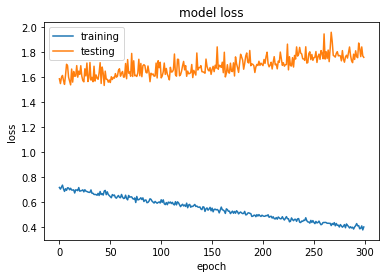

In [202]:
#plotting our model.
#plt.plot(cnnhistory.history['loss'])#loss
#plt.plot(cnnhistory.history['val_loss'])#loss of value
#plt.title('model loss')#total loss of the model.
#plt.ylabel('loss')#varable on the dependent axis
#plt.xlabel('epoch')#variable on the independent access.
#plt.legend(['training', 'testing'], loc='upper left')
#plt.show()


In [203]:
#saving the model so that it is used again.
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Saving the weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)


Saved trained model at /home/harsharoddam/saved_models/Emotion_Voice_Detection_Model.h5 


In [204]:
#converting the saved model to json type and making it flexible to edit whenever you want.
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [206]:
# loading the model and using it for current application.
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# loading the weights into our new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluating the loaded model and  test the testing data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(cnnXtesting, testingY, verbose=0)
#print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))


Loaded model from disk


In [207]:
predictions = loaded_model.predict(cnnXtesting, 
                         batch_size=64, 
                         verbose=1)

4/4 [==============================] - 1s 358ms/step


In [209]:
predictions1=predictions.argmax(axis=1)
abc = predictions1.astype(int).flatten()
goodpredictions = (lben.inverse_transform((abc)))
predictiondataframe = pd.DataFrame({'predictedvalues': goodpredictions})
predictiondataframe[:10]

In [215]:
actual=testingY.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lben.inverse_transform((abc123)))

In [216]:
actualdataframe = pd.DataFrame({'actualvalues': actualvalues})
actualdataframe[:10]

,actualvalues
0,male_sad
1,male_calm
2,male_angry
3,male_happy
4,female_happy
5,male_sad
6,female_angry
7,female_sad
8,female_fearful
9,female_sad


In [217]:
finaldataframe = actualdataframe.join(predictiondataframe)

In [219]:
finaldataframe.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,15
female_calm,18
female_fearful,19
female_happy,17
female_sad,17
male_angry,26
male_calm,16
male_fearful,39
male_happy,35


In [220]:
finaldataframe.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,22
female_calm,10
female_fearful,11
female_happy,21
female_sad,19
male_angry,46
male_calm,13
male_fearful,52
male_happy,22


In [221]:
finaldataframe.to_csv('Predictions.csv', index=False)

In [222]:
data, sampling_rate = librosa.load('output10.wav')

1/1 [==============================] - 0s 15ms/step


array(['male_angry'], dtype=object)

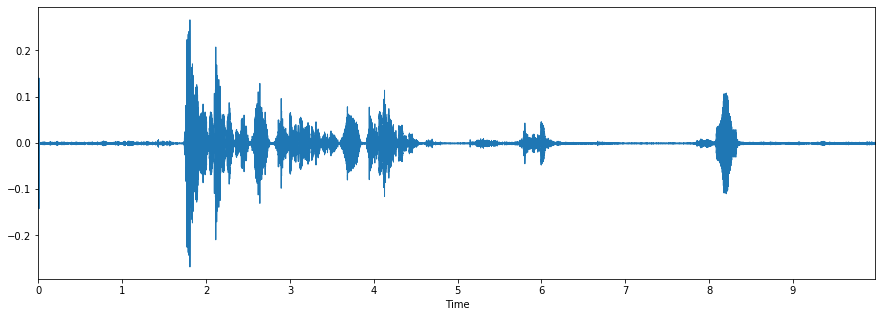

In [234]:
#check the output by compiling it again and again fo each current input you give.
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)
#testing the current input with the model that is already trained.
X, sample_rate = librosa.load('output10.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
Xlive = mfccs
livedataframe2 = Xlive
livedataframe2= pd.DataFrame(data=livedataframe2)
livedataframe2 = livedataframe2.stack().to_frame().T
twodim= np.expand_dims(livedataframe2, axis=2)
livepredictions = loaded_model.predict(twodim, 
                         batch_size=64, 
                         verbose=1)
livepredictions1=livepredictions.argmax(axis=1)
livea = livepredictions1.astype(int).flatten()
newlivepredictions = (lben.inverse_transform((livea)))
newlivepredictions